<a href="https://colab.research.google.com/github/geoskimoto/SNOTEL_ErrorAndOutlier_Tools/blob/main/Isolationforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Helper Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objs as go
from functools import reduce
import requests
import xml.dom.minidom as minidom
import xml.etree.ElementTree as ET
import datetime

In [2]:
# pip install eif

In [3]:
import eif

ModuleNotFoundError: ignored

In [8]:
# Web Call to Access and Download Data of a Single Station from AWDB Web Service (SOAP API)

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):

  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>STATIONTRIPLETS</stationTriplets>
        <elementCd>ELEMENTCD</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>BEGINDATE</beginDate>
        <endDate>ENDDATE</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting date ranges that include Feb 29.
  #Possible element codes: PREC, WTEQ (Water Equivalent/SWE)
  

  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
  SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
  SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
  SOAP_current = SOAP_current.replace("ENDDATE", enddate)

  response_current = requests.post(URL, data=SOAP_current, headers=headers)
  xmldoc = minidom.parseString(response_current.text)

  val_length = len(xmldoc.getElementsByTagName('values'))
  data = pd.DataFrame([xmldoc.getElementsByTagName('values')[i].firstChild.data for i in range(0,val_length)])

  date = datetime.datetime.strptime(begindate, "%m/%d/%Y").date()  #https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior; .date() after .strptime just tells it to make it a datetime object.  Def necessary.
  # print(date)
  Date = []                                                       
  for i in range(0, val_length): 
    date += datetime.timedelta(days=1)
    Date.append((date))

  # {str(xmldoc.getElementsByTagName('stationTriplet')[0].firstChild.data):{Date[j]:xmldoc.getElementsByTagName('values')[j].firstChild.data} for j in range(3)}

  data['Date'] = Date
  data.columns = [f'{elementCD}','Date']
  data.set_index('Date', inplace=True)
  
  data[f'{elementCD}'] = list(map(lambda x: float(x), data[f'{elementCD}']))
  
  return data

In [9]:
# Function to Download Multiple Stations at a time from AWDB Web Service

# stations = ['401:OR:SNTL', '471:ID:SNTL', '591:WA:SNTL']
def getData(stations, parameter_of_interest, begindate, enddate):
  # data = []
  # data_singleDF
  # for i in stations:
  #   data.append(SOAP_Call(stationtriplets=i,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate))

  # data_singleDF =
 
  data_singleDF = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [SOAP_Call(stationtriplets=j,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate) for j in stations])
  # data_singleDF.rename(columns='bla')
  data_singleDF.columns = [f'{j}' for j in stations]

  # index = np.array([data_singleDF.columns.values, data_singleDF.iloc[1].values])
  # data_singleDF = pd.MultiIndex.from_arrays(index)
  # data_singleDF = data_singleDF.iloc[1:]

  # data_singleDF.xs('price', axis=1, level=1, drop_level=False)


  return data_singleDF

# IF testing

In [10]:
F1  = eif.iForest(TAVG_array, ntrees=200, sample_size=256, ExtensionLevel=1)

In [ ]:
F1.compute_paths(X_in=TAVG_array)

In [1]:
F1

NameError: ignored

In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

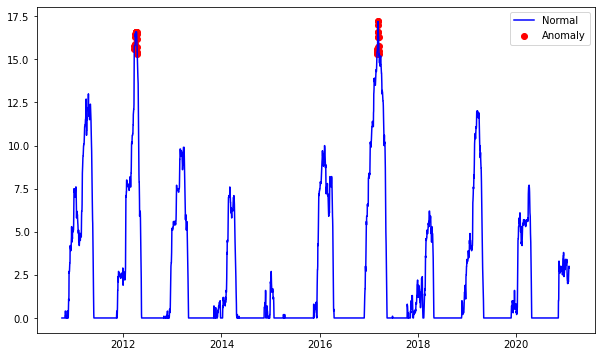

In [34]:
TAVG = getData(['401:OR:SNTL'], 'WTEQ', '10/01/2010', '01/30/2021')

outliers_fraction = 0.01
data = np.array(TAVG.dropna())
# data = TAVG_array
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
TAVG['anomaly2'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = TAVG.loc[TAVG['anomaly2'] == -1] #anomaly

ax.plot(TAVG.index, TAVG['401:OR:SNTL'], color='blue', label = 'Normal')
ax.scatter(a.index, a['401:OR:SNTL'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [28]:
a = TAVG.loc[TAVG['anomaly2'] == -1] 

In [29]:
a

,401:OR:SNTL,anomaly2
Date,,
2010-11-24,13.82,-1
2010-11-25,15.98,-1
2010-12-05,24.26,-1
2010-12-06,24.44,-1
2010-12-18,26.06,-1
...,...,...
2020-09-05,69.80,-1
2020-09-07,66.02,-1
2020-10-26,22.10,-1


In [21]:
predictions = model.predict(data)
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
TAVG['anomaly2'] = predictions
# pd.DataFrame(predictions)


In [27]:
TAVG

,401:OR:SNTL,anomaly2
Date,,
2010-10-02,60.08,1
2010-10-03,59.18,1
2010-10-04,49.10,1
2010-10-05,42.62,1
2010-10-06,46.22,1
...,...,...
2021-01-27,24.80,-1
2021-01-28,30.74,1
2021-01-29,33.44,1


In [37]:
pd.DataFrame(model.predict(data)).sample(25)

,0
3671,1
2360,1
3370,1
867,1
2048,1
1670,1
3058,-1
2517,1
214,1
2820,1


In [31]:
TAVG

,401:OR:SNTL,anomaly2
Date,,
2010-10-02,60.08,NaN
2010-10-03,59.18,NaN
2010-10-04,49.10,NaN
2010-10-05,42.62,NaN
2010-10-06,46.22,NaN
...,...,...
2021-01-27,24.80,NaN
2021-01-28,30.74,NaN
2021-01-29,33.44,NaN
